### 3.2.1 EDA

#### 库和文件导入

In [1]:
import pandas as pd
import numpy as np

import datetime 
import time

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
events_df = pd.read_csv('events.csv')
category_tree_df = pd.read_csv('category_tree.csv')
items1 = pd.read_csv('item_properties_part1.csv')
items2 = pd.read_csv('item_properties_part2.csv')
items_df = pd.concat([items1, items2])

#### 文件内容探索

In [3]:
items_df.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [4]:
times =[]
for i in items_df['timestamp']:
    times.append(datetime.datetime.fromtimestamp(i//1000.0)) 

items_df['timestamp'] = times
items_df.head()

,timestamp,itemid,property,value
0,2015-06-28 11:00:00,460429,categoryid,1338
1,2015-09-06 11:00:00,206783,888,1116713 960601 n277.200
2,2015-08-09 11:00:00,395014,400,n552.000 639502 n720.000 424566
3,2015-05-10 11:00:00,59481,790,n15360.000
4,2015-05-17 11:00:00,156781,917,828513


**timestamp** Unix Epoch格式<br>**itemid** 商品id，独特<br>
**propertyid** 商品属性，例如种类、存货数量<br>
**value** 对应属性的数量。其中`n`表示后面的价值是数字

In [5]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [6]:
events_df.tail()

,timestamp,visitorid,event,itemid,transactionid
2756096,1438398785939,591435,view,261427,NaN
2756097,1438399813142,762376,view,115946,NaN
2756098,1438397820527,1251746,view,78144,NaN
2756099,1438398530703,1184451,view,283392,NaN
2756100,1438400163914,199536,view,152913,NaN


In [7]:
events_df[events_df.transactionid.notnull()].event.unique()

array(['transaction'], dtype=object)

In [8]:
events_df[events_df.transactionid.isnull()].event.unique()

array(['view', 'addtocart'], dtype=object)

In [9]:
print(events_df['event'].value_counts())

event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64


<Axes: xlabel='event', ylabel='count'>

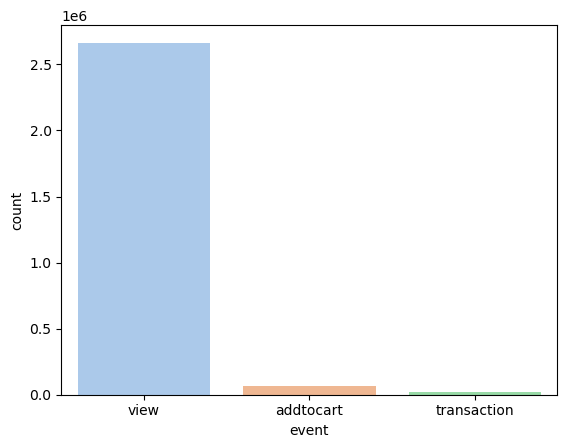

In [10]:
sns.countplot(x= 'event', data=events_df, palette="pastel")

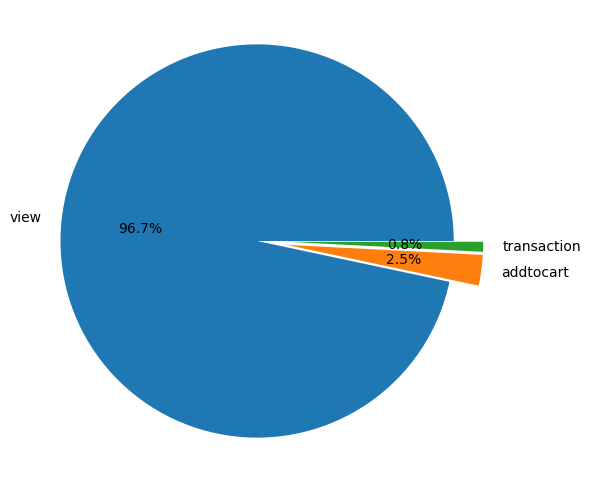

In [11]:
data = events_df.event.value_counts()
labels = data.index
sizes = data.values
explode = (0, 0.15, 0.15)

plt.subplots(figsize=(6,6))
plt.pie(sizes, explode=explode, labels=labels,autopct='%1.1f%%', shadow=False, startangle=0)
plt.axis('equal')
plt.show()

**timestamp** Unix Epoch格式<br>
**visitorid** 访问者id，独特<br>**event** 访问者行为，包括“浏览”，“加入购物车”和“交易”<br>
**itemid** 商品id，独特<br>**transactionid** 如果访问者交易，则产生

In [12]:
category_tree_df.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [13]:
items_df.loc[(items_df.property == 'categoryid') & (items_df.value == '1016')].sort_values('timestamp').head()

,timestamp,itemid,property,value
7236969,2015-05-10 11:00:00,6777,categoryid,1016
8597591,2015-05-10 11:00:00,161686,categoryid,1016
9496408,2015-05-10 11:00:00,276491,categoryid,1016
6880131,2015-05-10 11:00:00,443058,categoryid,1016
7202531,2015-05-10 11:00:00,462004,categoryid,1016


**categpryid** 子种类<br>
**parentid** 母种类

#### 进一步数据探索

按照客户是否交易，将客户分为两类

In [14]:
all_customers = events_df['visitorid'].unique()

print("Unique visitors:", all_customers.size)
print('Total visitors:', events_df['visitorid'].size)

Unique visitors: 1407580
Total visitors: 2756101


有交易的客户的数量

In [15]:
customer_purchased = events_df[events_df.transactionid.notnull()].visitorid.unique()
customer_purchased.size

11719

In [16]:
customer_purchased[:10]

array([ 599528,  121688,  552148,  102019,  189384,  350566,  404403,
        505565,  945184, 1406787], dtype=int64)

某客户行为记录示例（“浏览” => “添加至购物车” => “交易”）

In [17]:
events_df[events_df.visitorid == 102019].sort_values('timestamp')

,timestamp,visitorid,event,itemid,transactionid
19690,1433175714335,102019,view,49521,NaN
19501,1433175801314,102019,addtocart,49521,NaN
14842,1433175812596,102019,view,150318,NaN
19573,1433175871497,102019,view,49521,NaN
8701,1433175894837,102019,view,49521,NaN
19708,1433175945872,102019,view,150318,NaN
8740,1433176042269,102019,view,49521,NaN
814,1433176736375,102019,transaction,150318,13556.0
19724,1433176736422,102019,transaction,49521,13556.0


拥有categoryid并记录于property的商品

In [18]:
items_new = items_df.loc[items_df.property.isin(['categoryid', 'available']), :]
print("items with categoryid and available as property:", items_new.size)
items_new.head(20)

items with categoryid and available as property: 9167412


,timestamp,itemid,property,value
0,2015-06-28 11:00:00,460429,categoryid,1338
5,2015-07-05 11:00:00,285026,available,0
15,2015-07-19 11:00:00,186518,available,0
79,2015-06-07 11:00:00,423682,available,0
82,2015-06-14 11:00:00,316253,available,1
96,2015-07-19 11:00:00,430459,available,0
101,2015-05-31 11:00:00,411262,available,0
116,2015-09-06 11:00:00,50372,available,0
119,2015-09-06 11:00:00,289043,available,0
133,2015-06-28 11:00:00,365407,available,0


按照event和itemid汇总

In [19]:
grouped = events_df.groupby('event')['itemid'].apply(list)
grouped

event
addtocart      [5206, 10572, 255275, 356475, 312728, 63312, 1...
transaction    [356475, 15335, 81345, 150318, 310791, 54058, ...
view           [355908, 248676, 318965, 253185, 367447, 22556...
Name: itemid, dtype: object

哪些商品产生最多“浏览”记录

<Axes: >

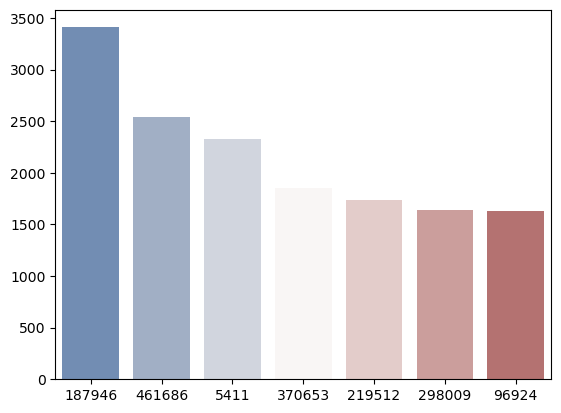

In [135]:
import operator
views = grouped['view']
count_view ={}

views = np.array(views[:])
unique, counts = np.unique(views, return_counts=True)
count_view = dict(zip(unique, counts))
sort_count_view = sorted(count_view.items(), key = operator.itemgetter(1), reverse = True)

x = [i[0] for i in sort_count_view[:7]]
y = [i[1] for i in sort_count_view[:7]]
sns.barplot(x = x, y = y, order=x, palette="vlag")

哪些商品产生最多“添加至购物车”记录

<Axes: >

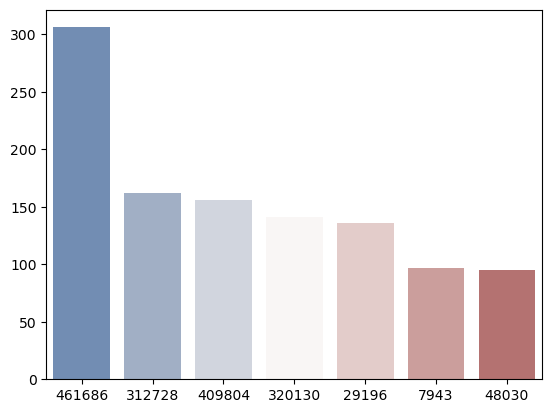

In [21]:
addtocart = grouped['addtocart']
count_addtocart ={}

addtocart = np.array(addtocart[:])
unique, counts = np.unique(addtocart, return_counts=True)
count_addtocart = dict(zip(unique, counts))
sort_count_addtocart = sorted(count_addtocart.items(), key = operator.itemgetter(1), reverse = True)

x = [i[0] for i in sort_count_addtocart[:7]]
y = [i[1] for i in sort_count_addtocart[:7]]
sns.barplot(x = x, y = y, order=x, palette="vlag")

哪些商品产生最多“交易”记录

<Axes: >

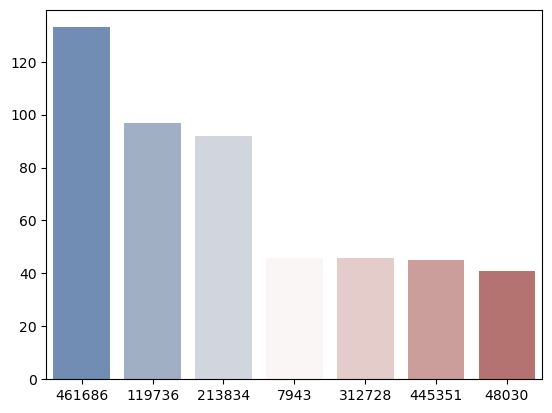

In [22]:
transaction = grouped['transaction']
count_transaction ={}

transaction = np.array(transaction[:])
unique, counts = np.unique(transaction, return_counts=True)
count_transaction = dict(zip(unique, counts))
sort_count_transaction = sorted(count_transaction.items(), key = operator.itemgetter(1), reverse = True)

x = [i[0] for i in sort_count_transaction[:7]]
y = [i[1] for i in sort_count_transaction[:7]]
sns.barplot(x = x, y = y, order=x, palette="vlag")

### 3.2.2 推荐系统构建

In [23]:
from lightfm import LightFM
from lightfm.evaluation import auc_score
from scipy.sparse import coo_matrix
from sklearn import preprocessing

D:\anaconda3\envs\pandas_learning\Lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [24]:
events_df = events_df.assign(date=pd.Series(datetime.datetime.fromtimestamp(i/1000).date() for i in events_df.timestamp))
events_df = events_df.sort_values('date').reset_index(drop=True)
events_df = events_df[['visitorid','itemid','event', 'date']]
events_df.head()

,visitorid,itemid,event,date
0,910284,331446,view,2015-05-03
1,1324815,292237,view,2015-05-03
2,398588,269842,view,2015-05-03
3,139680,465621,addtocart,2015-05-03
4,108814,247909,view,2015-05-03


In [25]:
start_date = '2015-5-3'
end_date = '2015-5-18'
fd = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date()
events_df = events_df[(events_df.date >= fd(start_date)) & (events_df.date <= fd(end_date))]

In [26]:
split_point = int(np.round(events_df.shape[0]*0.8))
events_train = events_df.iloc[0:split_point]
events_test = events_df.iloc[split_point::]
events_test = events_test[(events_test['visitorid'].isin(events_train['visitorid'])) & (events_test['itemid'].isin(events_train['itemid']))]

In [27]:
id_cols = ['visitorid','itemid']
trans_cat_train = dict()
trans_cat_test = dict()

for k in id_cols:
    cate_enc = preprocessing.LabelEncoder()
    trans_cat_train[k] = cate_enc.fit_transform(events_train[k].values)
    trans_cat_test[k] = cate_enc.transform(events_test[k].values)

In [28]:
ratings = dict()

cate_enc = preprocessing.LabelEncoder()
ratings['train'] = cate_enc.fit_transform(events_train.event)
ratings['test'] = cate_enc.transform(events_test.event)

In [29]:
n_users = len(np.unique(trans_cat_train['visitorid']))
n_items = len(np.unique(trans_cat_train['itemid']))

In [30]:
rate_matrix = dict()
rate_matrix['train'] = coo_matrix((ratings['train'], 
                                   (trans_cat_train['visitorid'], 
                                    trans_cat_train['itemid'])), 
                                  shape=(n_users,n_items))
rate_matrix['test'] = coo_matrix((ratings['test'], 
                                  (trans_cat_test['visitorid'], 
                                   trans_cat_test['itemid'])), 
                                 shape=(n_users,n_items))

In [31]:
model = LightFM(no_components = 10, loss = 'warp')
model.fit(rate_matrix['train'], epochs = 100, num_threads = 1)

### 3.2.3 算法评估和检验

#### 算法评估

In [32]:
auc_score(model, rate_matrix['train'], num_threads = 1).mean()

0.998509

In [33]:
auc_score(model, rate_matrix['test'], num_threads = 1).mean()

0.82797575

#### 算法检验

In [210]:
n_recommendations = 5
random_users = np.random.choice(rate_matrix['test'].row, size=n_recommendations, replace=False)

In [217]:
def sample_recommendation(model, data, user_ids, n_items):
    results = {}

    for user_id in user_ids:
        known_positives = events_df[events_df['visitorid'] == user_id]['itemid'].values
        scores = model.predict(np.full(n_items, user_id, dtype=np.int32), np.arange(n_items))
        top_items = np.argsort(-scores)

        print(f"User {user_id}")
        print(" Known positives:")
        for x in known_positives[:3]:
            print(f" {x}")

        print(" Recommended:")
        recommendations = []
        for x in top_items[:3]:
            print(f" {x} with score {scores[x]}")
            recommendations.append((x, scores[x]))

        results[user_id] = {
            'known_positives': known_positives,
            'recommendations': recommendations
        }

    return results

In [218]:
sample_recommendation(model, rate_matrix['test'], random_users, n_items)

User 29626
 Known positives:
 Recommended:
 67531 with score 1.9106998443603516
 6117 with score 1.7165738344192505
 35257 with score 1.7041709423065186
User 37825
 Known positives:
 80402
 Recommended:
 37351 with score 1.9044865369796753
 65916 with score 1.8094706535339355
 45792 with score 1.7193636894226074
User 106611
 Known positives:
 Recommended:
 62277 with score 2.531468391418457
 45370 with score 2.4186222553253174
 53714 with score 2.340581178665161
User 103684
 Known positives:
 Recommended:
 54746 with score 2.6300697326660156
 7386 with score 2.405660629272461
 22798 with score 2.256413459777832
User 62406
 Known positives:
 198784
 188069
 328486
 Recommended:
 53368 with score 2.226672410964966
 812 with score 2.2056212425231934
 41601 with score 2.094320774078369


{29626: {'known_positives': array([], dtype=int64),
  'recommendations': [(67531, 1.9106998),
   (6117, 1.7165738),
   (35257, 1.704171)]},
 37825: {'known_positives': array([80402], dtype=int64),
  'recommendations': [(37351, 1.9044865),
   (65916, 1.8094707),
   (45792, 1.7193637)]},
 106611: {'known_positives': array([], dtype=int64),
  'recommendations': [(62277, 2.5314684),
   (45370, 2.4186223),
   (53714, 2.3405812)]},
 103684: {'known_positives': array([], dtype=int64),
  'recommendations': [(54746, 2.6300697),
   (7386, 2.4056606),
   (22798, 2.2564135)]},
 62406: {'known_positives': array([198784, 188069, 328486,  88305], dtype=int64),
  'recommendations': [(53368, 2.2266724),
   (812, 2.2056212),
   (41601, 2.0943208)]}}

In [219]:
for user_id in random_users:
    print(events_df[events_df['visitorid'] == user_id])

Empty DataFrame
Columns: [visitorid, itemid, event, date]
Index: []
       visitorid  itemid event        date
81820      37825   80402  view  2015-05-07
Empty DataFrame
Columns: [visitorid, itemid, event, date]
Index: []
Empty DataFrame
Columns: [visitorid, itemid, event, date]
Index: []
        visitorid  itemid event        date
258542      62406  198784  view  2015-05-16
260868      62406  188069  view  2015-05-16
264801      62406  328486  view  2015-05-16
265218      62406   88305  view  2015-05-16


### 3.2.4 可视化展示

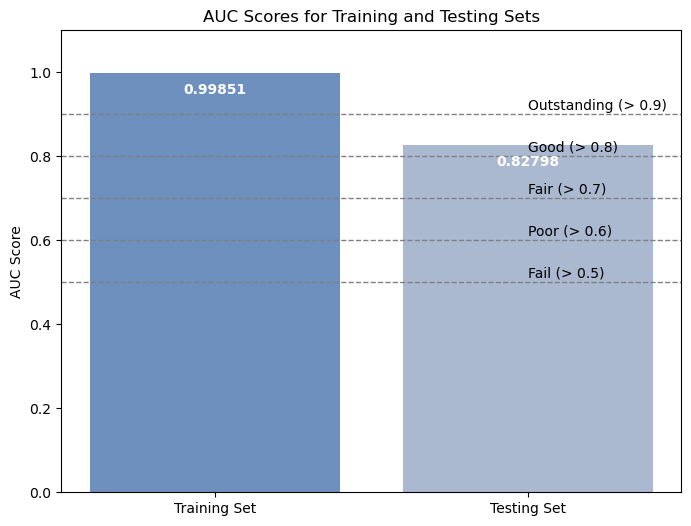

In [220]:
auc_scores = {'Training Set': 0.998509, 'Testing Set': 0.82797575}

thresholds = {
    'Outstanding': 0.9,
    'Good': 0.8,
    'Fair': 0.7,
    'Poor': 0.6,
    'Fail': 0.5
}

labels = list(auc_scores.keys())
values = list(auc_scores.values())

palette = sns.color_palette("vlag")
vlag_blue, vlag_red = palette.as_hex()[:2]
plt.figure(figsize=[8,6])
bars = plt.bar(labels, values, color=[vlag_blue, vlag_red])

plt.ylim(0, 1.1)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, value - 0.05, f'{value:.5f}', ha='center', color='white', fontweight='bold')

for name, score in thresholds.items():
    plt.axhline(y=score, color='gray', linestyle='--', linewidth=1)
    plt.text(len(auc_scores) - 1, score + 0.02, f'{name} (> {score})', va='center', color='black', fontsize=10)

plt.ylabel('AUC Score')
plt.title('AUC Scores for Training and Testing Sets')
plt.show()

In [231]:
def visualize_recommendations(results):
    data = {
        'User': [],
        'Item': [],
        'Score': [],
        'Type': [],
        'Known Positives': []
    }

    for user_id, user_data in results.items():
        known_positives = user_data['known_positives']
        recommendations = user_data['recommendations']

        if not np.all(known_positives == '-'):
            for item_id in known_positives:
                if item_id != '-':
                    data['User'].append(str(user_id))
                    data['Item'].append(str(item_id))
                    data['Score'].append('-')
                    data['Type'].append('Known Positive')
                    data['Known Positives'].append(str(item_id))
                    
        for item_id, score in recommendations:
            data['User'].append(str(user_id))
            data['Item'].append(str(item_id))
            data['Score'].append(score)
            data['Type'].append('Recommended')
            data['Known Positives'].append('-')

    df = pd.DataFrame(data)
    df['Score'] = df['Score'].replace('-', np.nan).astype(float)

    plt.figure(figsize=(8, 6))
    sns.barplot(x='User', y='Score', hue='Type', data=df, palette='pastel')
    plt.title('Recommended Items and Known Positives per User')
    plt.xlabel('User ID')
    plt.ylabel('Score/Presence')
    plt.legend(loc='upper right')
    plt.show()

User 29626
 Known positives:
 Recommended:
 67531 with score 1.9106998443603516
 6117 with score 1.7165738344192505
 35257 with score 1.7041709423065186
User 37825
 Known positives:
 80402
 Recommended:
 37351 with score 1.9044865369796753
 65916 with score 1.8094706535339355
 45792 with score 1.7193636894226074
User 106611
 Known positives:
 Recommended:
 62277 with score 2.531468391418457
 45370 with score 2.4186222553253174
 53714 with score 2.340581178665161
User 103684
 Known positives:
 Recommended:
 54746 with score 2.6300697326660156
 7386 with score 2.405660629272461
 22798 with score 2.256413459777832
User 62406
 Known positives:
 198784
 188069
 328486
 Recommended:
 53368 with score 2.226672410964966
 812 with score 2.2056212425231934
 41601 with score 2.094320774078369


C:\Users\czxip\AppData\Local\Temp\ipykernel_8756\3986153150.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Score'] = df['Score'].replace('-', np.nan).astype(float)
D:\anaconda3\envs\pandas_learning\Lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
D:\anaconda3\envs\pandas_learning\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


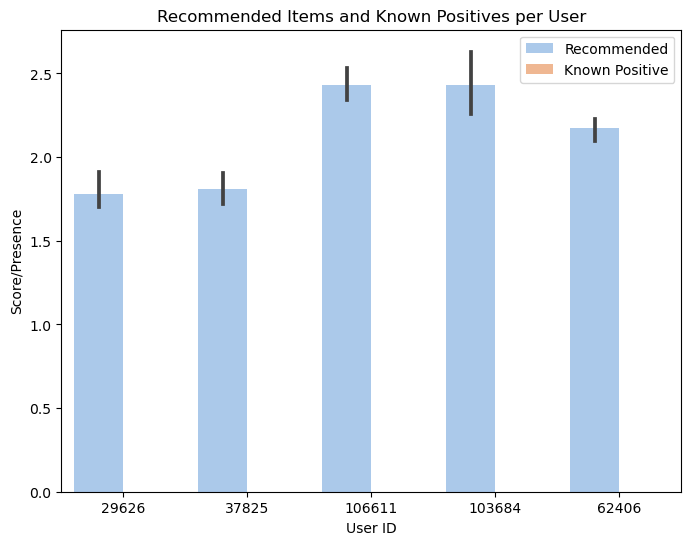

In [232]:
visualize_recommendations(sample_recommendation(model, rate_matrix['test'], random_users, n_items))